## Notebook to determine ROIs for overlapping cells in 3d spot-based transcriptomics data

In [1]:
%load_ext autoreload
%autoreload 2


#### Basic imports:

In [2]:
import os
# from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
import anndata
import time

perf = time.perf_counter()
perf_ = perf

print(time.perf_counter()-perf)

0.0001046992838382721


#### Define parameters

In [3]:
# SSAM vector field resolution:
um_per_pixel = 2.5

# SSAM pandwidth:
bw = 1

# KNN diffusion iterations to move spots to z-axis zero mean:
z_centralization_iters = 20

# {0:'xenium_mouse_brain',1:'merfish_mouse_brain',2:'merfish_liver'}
dataset =0

file_root = '/dh-projects/ag-ishaque/analysis/tiesmeys/spot-data-z-axis-incoherence/src'


## Define & load data

####  0: Xenium Mouse brain dataset:

In [6]:

if dataset == 0:
    
    perf_=time.perf_counter()

    adata = anndata.read_h5ad(os.path.join(file_root,
                '../../../../raw_data/Xenium-benchmark/spatial//ms_brain_multisection1.h5ad'),)



    coords = adata.uns['spots'].copy()
    coords = coords[~(coords.feature_name.str.contains("BLANK") | coords.feature_name.str.contains("NegControl"))]

    df = coords[['x_location' ,'y_location' ,'z_location','feature_name' ]]#,'cell_id','cell_type_louis','cell_id_louis']]

    # replace the feature_name Ccn2 with Ctgf, which is present in the scRNAseq data:
    # df.loc[df.feature_name=='Ccn2','feature_name'] = 'Ctgf'
    df.columns = ['x','y','z','gene' ,]#'cell_id','cell_type_louis','cell_id_louis']
    df = df[~df.gene.str.contains('Blank')][::1]
    df['gene']=df['gene'].astype('category')

    # spot_df = df.copy()
    genes = sorted(df.gene.unique())
    
    print(f'Loading time: {time.perf_counter()-perf_}')
    perf_=time.perf_counter()

del coords,
df


Loading time: 56.24754364788532


x          y          z     gene
transcript_id                                            
281474976710664  4843.0460  6427.7300  19.068869  Bhlhe40
281474976710665  4844.6330  6223.1826  18.520160    Parm1
281474976710667  4842.9434  6478.3105  18.500109  Bhlhe40
281474976710669  4843.9414  6344.5503  15.016154     Lyz2
281474976710670  4843.1626  6632.1120  15.394680     Dkk3
...                    ...        ...        ...      ...
281977488696810  3656.9348  5991.1730  14.609873   Zfp536
281977488696812  3656.0498  5359.0933  17.772276    Parm1
281977488696814  3656.7720  5429.7690  15.828760    Meis2
281977488696815  3656.8064  5433.3677  18.079390   Acsbg1
281977488696818  3656.5654  5391.0160  14.229190    Trpc4

[62384369 rows x 4 columns]

Pre-processing time: 60.51173570379615


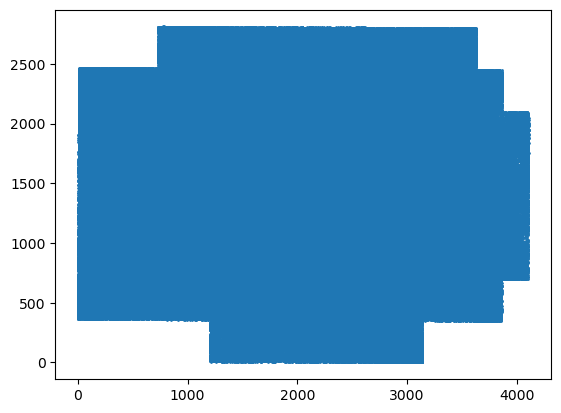

In [7]:
df.x-=df.x.min()
df.y-=df.y.min()

df.x/=um_per_pixel
df.y/=um_per_pixel

df.x-=df.x.min()
df.y-=df.y.min()

print(f'Pre-processing time: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

plt.scatter(df.x,df.y,s=1,alpha=0.01)

In [8]:
perf_=time.perf_counter()

from src import ovrlp

perf_=time.perf_counter()

roi_df = ovrlp.find_overlaps(df,threshold_fraction=0.4,density_weight=0.3,min_distance=20)

print(f'Ovrl.py runtime: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

# re=run to compute divergence map:
_, _, divergence, signal, divergence_map = ovrlp.compute_divergence(df, genes, plot=False,
                                            threshold_fraction=0.4,density_weight=0.3,
                                            min_distance=20,return_maps=True)




Ovrl.py runtime: 258.41008028015494


#### Load snRNAseq data for cell typing:

In [10]:
# We assign each spot to the nearest celltype, using an annotated single-cell dataset:

# Load the single-cell dataset:
adata_snrna = anndata.read_h5ad('/dh-projects/ag-ishaque/raw_data/Xenium-benchmark/scRNAseq/adata_multisection_withclusters_only_nuclei_annotation.h5ad')
adata_snrna = adata_snrna[:,adata_snrna.var.index.isin(genes)]
adata_snrna.obs = adata_snrna.obs[['celltype_annotation']]

# adata_sncrna = anndata.concat([adata_snrna,adata_scrna],axis=0,join='outer')
adata_sncrna = adata_snrna
adata_sncrna.obs['celltype_coarse'] = adata_sncrna.obs.celltype_annotation.apply(lambda x: x.split(' ')[0])

adata_sncrna.obs.index = ('Cell_'+pd.Series(np.arange(adata_sncrna.shape[0])).astype(str)).values


# define a signature matrix of mean celltype expression profiles:
celltypes = sorted(adata_sncrna.obs.celltype_coarse.unique())
signatures = pd.DataFrame(index=genes,columns=celltypes).drop(['Noise','nan','?'],axis=1)

# fill the signatures with mean expression values:
for celltype in signatures.columns:
    subset = adata_sncrna.X[adata_sncrna.obs.celltype_coarse==celltype,:]
    subset = pd.Series(np.nan_to_num(np.array(subset.mean(0)).squeeze()),
                       index=adata_sncrna.var.index)

    signatures[celltype] = subset[genes].values / (subset.sum()+1)


/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/tiesmeys/miniconda3/envs/spatial2022/lib/python3.9/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


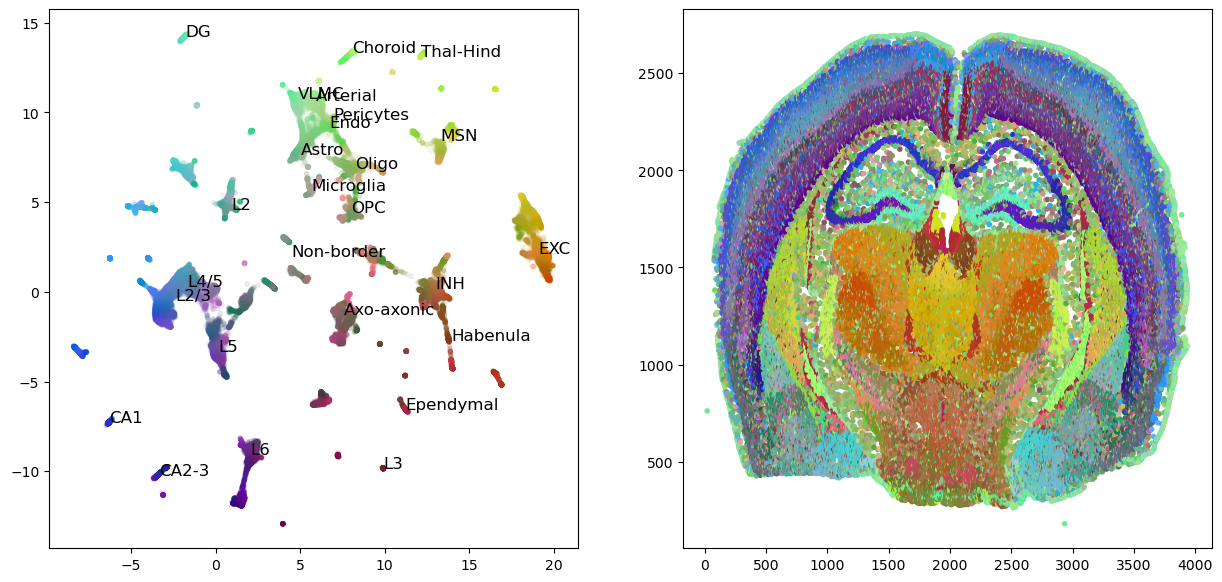

In [12]:
import random

perf_=time.perf_counter()

random.seed(42)

vis = ovrlp.Visualizer()

vis.fit(df,signature_matrix=signatures)

print(f'SSAM/visualization runtime: {time.perf_counter()-perf_}')
perf_=time.perf_counter()

vis.plot_fit()

Text(0.5, 1.0, 'incoherence')

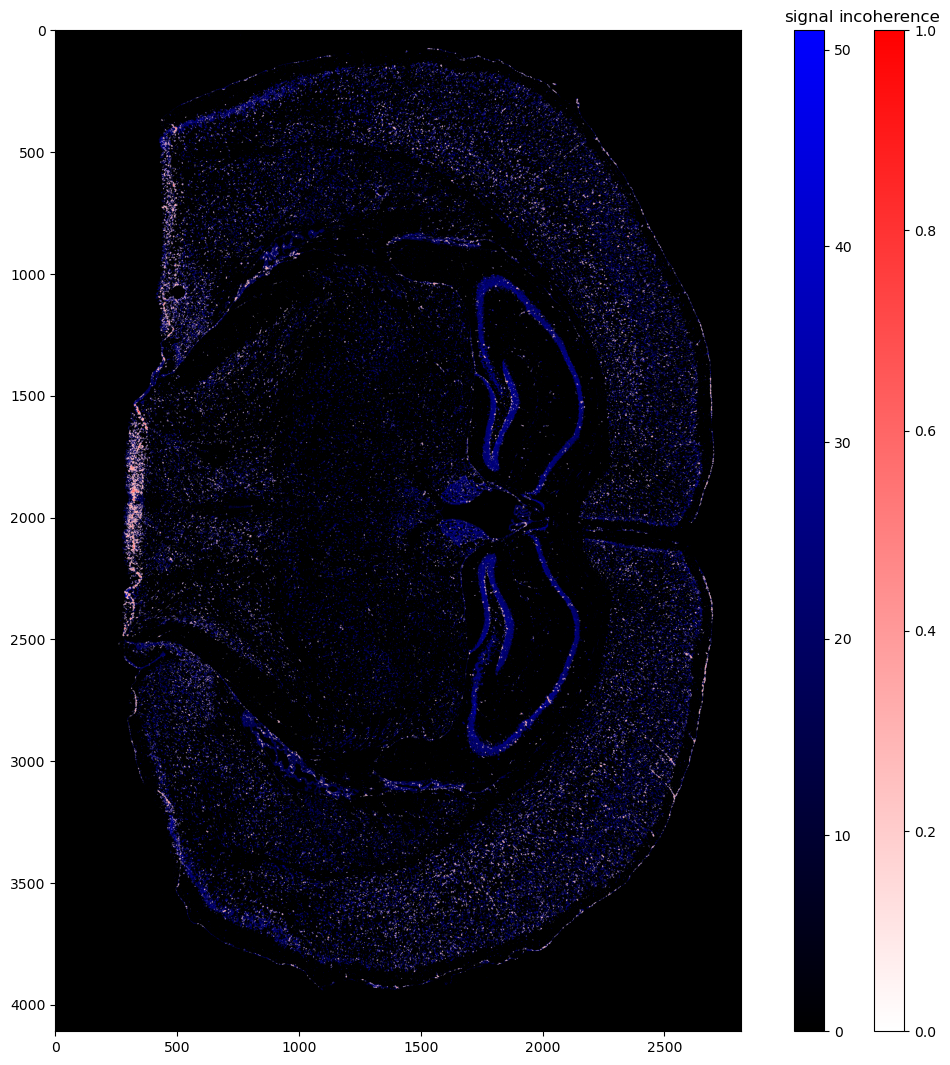

In [15]:
from matplotlib.colors import LinearSegmentedColormap


# rois_x, rois_y, divergence, signal, divergence_map = ovrlp.compute_divergence(df, genes, plot=False,
#                                             threshold_fraction=0.4,density_weight=0.3,
#                                             min_distance=20,return_maps=True)

BlGr = LinearSegmentedColormap.from_list('BlGr', ['black','blue'], N=256)
TrRd = LinearSegmentedColormap.from_list('TrRd', [[1.0,1.0,1.0,1.0],[1.0,0.0,0.0,1.0]], N=256)

f, (p, b1,b2) = plt.subplots(1, 3, width_ratios=[23, 1,1],figsize=(11,13))

handle_signal_alpha = (signal>(np.max(signal)/5)).astype(float)
handle_signal = p.imshow(signal,cmap=BlGr,alpha=handle_signal_alpha)
p.set_facecolor('black')

incoherence = divergence_map*signal
incoherence/=incoherence.max()
incoherence_alpha = (incoherence>(np.max(incoherence)/5)).astype(float)
handle_divergence = p.imshow(incoherence,cmap=TrRd,alpha=incoherence_alpha)

plt.colorbar(handle_signal,cax=b1)
plt.colorbar(handle_divergence,cax=b2)

b1.set_title('signal')
b2.set_title('incoherence')


instance visualization runtime: 105.82308549620211


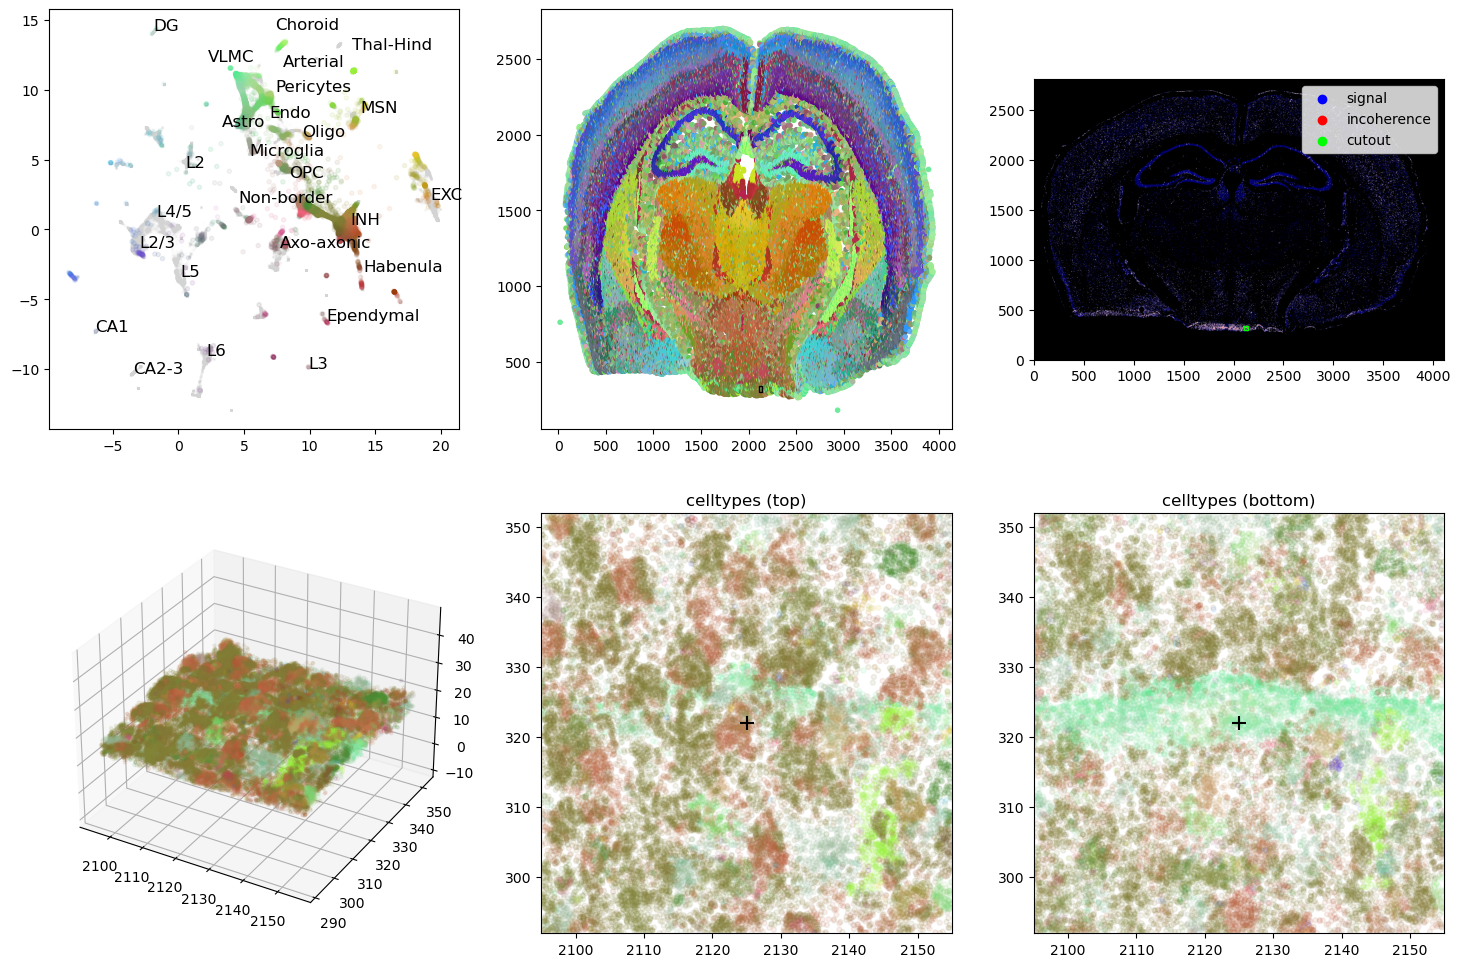

In [28]:
import matplotlib.patches as patches

perf_=time.perf_counter()

x,y = roi_df[['x','y']].iloc[0].values

vis.transform(x,y,df)

print(f'instance visualization runtime: {time.perf_counter()-perf_}')

ax = plt.subplot(232)
vis.plot_tissue()

# Create a Rectangle patch
rect = patches.Rectangle((x-20, y-20), 40, 40, linewidth=1, edgecolor='k', facecolor='none')
ax.add_patch(rect)

ax = plt.subplot(233)
plt.legend([plt.scatter([],[],color=c) for c in ['b','r','lime']],['signal','incoherence','cutout'])

handle_signal = ax.imshow(signal.T,cmap=BlGr,alpha=handle_signal_alpha.T)
ax.set_facecolor('black')

handle_divergence = ax.imshow(incoherence.T,cmap=TrRd,alpha=incoherence_alpha.T)
ax.invert_yaxis()

# Create a Rectangle patch
rect = patches.Rectangle((x-20, y-20), 40, 40, linewidth=1, edgecolor='lime', facecolor='none')
ax.add_patch(rect)


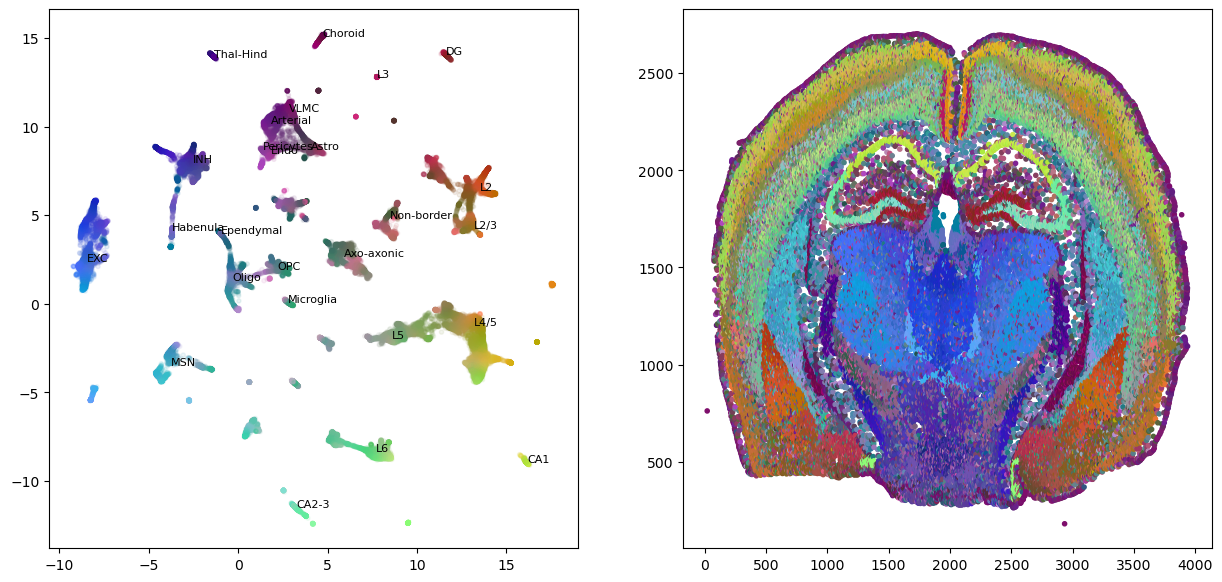

In [62]:
for i in range(1,5):
        
    x,y = roi_df[['x','y']].iloc[i].values

    vis.transform(x,y,df)

    print(f'instance visualization runtime: {time.perf_counter()-perf_}')

    plt.subplot(232)
    vis.plot_tissue()

    # Create a Rectangle patch
    rect = patches.Rectangle((x-15, y-15), 30, 30, linewidth=1, edgecolor='k', facecolor='none')
    ax.add_patch(rect)

    ax = plt.subplot(233)
    plt.legend([plt.scatter([],[],color=c) for c in ['b','r']],['signal','incoherence'])

    handle_signal = ax.imshow(signal.T,cmap=BlGr,alpha=handle_signal_alpha.T)
    ax.set_facecolor('black')

    handle_divergence = ax.imshow(incoherence.T,cmap=TrRd,alpha=incoherence_alpha.T)
    ax.invert_yaxis()

    # Create a Rectangle patch
    rect = patches.Rectangle((x-15, y-15), 30, 30, linewidth=1, edgecolor='w', facecolor='none')
    ax.add_patch(rect)